In [143]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
%matplotlib inline

# Note to grader : Just step through the notebook cell by cell, it should be just fine

# Coin Problem

We consider the following problem: Given 3 coins (coin 0, coin 1, and coin 2), each with unknown probabilities of getting heads when flipped, coin 0 is flipped, and based on its outcome, either coin 1 or coin 2 will be flipped. We seek to estimate those parameters, lambda, p1, and p2, each representing the probabilities of getting heads when each respective coin flipped. We generate a data set from given parameters, but the data set is only the outcomes of the 2nd coin flip (either coin 1 or coin 2 based on the first coin flip of coin 0). 

From a given data set, we use EM to estimate the parameters lambda, p1, and p2. We use 10 random initial guesses for those parameters, and use the local maxima attained by each to find the global max, which should be the original parameters for the generated data set.

In [22]:
# Generate data set X_1, ..., X_n of n samples, where X_i is from 3-coin-flips sample space
def gen_data(n, lam, p1, p2):
    '''
    Inputs
        n = # of samples desired
        lam = prob coin 0 is H (choosing coin 1)
        p1 = prob coin 1 is H
        p2 = prob coin 2 is H
    Output
        returns nx3 numpy array where ith draw is output[i,:]
    '''
    draws = np.empty((n,3))
    for i in xrange(n):
        # simulate draw for coin 0 (lamda)
        if np.random.rand() <= lam:
            # coin 1 simulate
            draws[i,:] = 1.*(np.random.rand(3)<= p1)
        else:
            # coin 2 simulate
            draws[i,:] = 1.*(np.random.rand(3)<= p2)
    
    # return the output
    return draws

In [38]:
def EM_alg_coin(draws, p_initial, eps=10**-4, print_iters=False):
    '''
    Input:
        draws = nx3 array of observed draws from coin 1 and coin 2 (unknown as to which coin came from however)
        p_initial = list initial guess of parameters --> [lam, p1, p2]
    Output:
        returns list of estimated parameters from EM algorithm
    '''
    # Initialization of shape n, p from p_initial, and the number of heads each trial
    n = draws.shape[0]
    p = np.array(p_initial)
    num_heads = np.sum(draws, axis=1)
    
    # Function to calculate mu_hat at each step. mu_hat = P(Y=H,X_i=x_i|theta_n), theta_n is the list of parameters p
    def update_mu(mu, p):
        for i in xrange(n):
            n_i = num_heads[i]
            t_i = 3. - n_i
            mu[i] = (p[0]*(p[1]**n_i)*((1. - p[1])**t_i)) / float(p[0]*(p[1]**n_i)*((1. - p[1])**t_i) + (1. - p[0])*(p[2]**n_i)*((1. - p[2])**t_i))
        return mu
    
    # Function to update the parameters of p = [lam, p1, p2], given mu_hat
    def update_p(mu):
        # These calculations here are intermediate sums/calculations to make writing the updates for lam, p1, and p2 easier
        # sum_mu is the sum over all mu's, while sum_mu_i is the sum of (1-mu) for all the mu's. Likewise for sum_mu_n 
        # and sum_mu_n_i
        sum_mu = np.sum(mu)
        sum_mu_i = float(n) - sum_mu
        sum_mu_n = np.sum(np.array(mu) * num_heads)
        sum_mu_n_i = np.sum(np.array(1. - mu) * num_heads)
        lam_new = sum_mu / float(n)
        p1_new = sum_mu_n / (3.*sum_mu)
        p2_new = sum_mu_n_i / (3.*sum_mu_i)
        return np.array([lam_new, p1_new, p2_new])
        
    # Initialize mu_hat
    mu_hat = np.zeros(n)
    
    # Convergence diff will be the inf-norm difference of the updated parameter vector p_new and old p, instantiated here as 1.0
    diff = 1.0
    p_new = p.copy()
    iters = 0
    
    while diff > eps and iters < 500:
        # Update mu_hat
        mu_hat = update_mu(mu_hat, p)
        
        # Calculate p_new
        p_new = update_p(mu_hat)
        
        # Calculate the inf norm difference (greatest element in the componentwise difference)
        diff = np.max(p - p_new)
        
        # Update parameter vector p and iters
        p = p_new
        
            
        iters += 1
    
    if print_iters:
        print '\tTotal runs: %d' % iters 
    
    # Calculate the likelihood of the estimation of the parameters. (l_hood will be the sum over 
    # the following calculation for each entry of mu_hat and draws)
    l_hood = 0
    for i in xrange(n):
        n_i = num_heads[i]
        t_i = 3. - n_i
        l_hood += mu_hat[i]*np.log(p[0]*(p[1]**n_i)*((1. - p[1])**t_i)) + (1. - mu_hat[i])*np.log((1. - p[0])*(p[2]**n_i)*((1. - p[2])**2))
    
    
    return p, l_hood
    
        

In [41]:
def run_EM_coin(data, iters=10, print_iters=False):
    # Run iters different starting points in (0,1)^3 space (parameter space)
    starting_points = [0.1*np.random.randint(2,10,3) for i in xrange(iters)]
    p_estimations = []
    likelihoods = []

    # For each of the starting points, record the parameter estimation attained and its corresponding likelihood function value
    count = 1
    for p_init in starting_points:
        print '\nIteration ' +str(count)
        p_est, l_hood = EM_alg_coin(draws, p_init, print_iters=True)
        p_estimations.append(p_est)
        likelihoods.append(l_hood)
        count += 1
    
    # Find and print the most likely parameters
    max_l_hood, max_index = max(likelihoods), np.argmax(likelihoods)
    print "\nThe parameters that are most likely: "
    print p_estimations[max_index]
    
    # if print_iters, print the initial guess, the estimated parameters and corresponding likelihood value
    if print_iters:
        print '\n Printout of Initial Gue'
        for i in xrange(iters):
            print "\nInitial Guess " + str(starting_points[i])
            print 'Parameters ' + str(p_estimations[i]) + ' and Likelihood ' + str(likelihoods[i])
    
    return p_estimations[max_index]

In [28]:
# Show that it worked! Generate our dataset to work with in the next cell
draws = gen_data(10000, 0.7, 0.75, 0.25)

In [46]:
# Run our method on the data set
parameters = run_EM_coin(draws, 5, True)


Iteration 1
	Total runs: 145

Iteration 2
	Total runs: 1

Iteration 3
	Total runs: 113

Iteration 4
	Total runs: 1

Iteration 5
	Total runs: 152

The parameters that are most likely: 
[ 0.69008052  0.74765523  0.26789008]

Initial Guess [ 0.4  0.9  0.2]
Parameters [ 0.69004752  0.7476672   0.26791451] and Likelihood -23098.901597

Initial Guess [ 0.2  0.7  0.5]
Parameters [ 0.22997209  0.7828001   0.54406403] and Likelihood -28748.8830586

Initial Guess [ 0.7  0.8  0.5]
Parameters [ 0.69006942  0.74765926  0.2678983 ] and Likelihood -23098.7226243

Initial Guess [ 0.3  0.4  0.3]
Parameters [ 0.37982725  0.68709239  0.54499372] and Likelihood -29642.2552864

Initial Guess [ 0.5  0.9  0.3]
Parameters [ 0.69008052  0.74765523  0.26789008] and Likelihood -23098.6318642


# Gaussian Mixture Models 

Here we are fitting data to a combination of gaussian distributions. For example, given some set of data, we may infer that the data was drawn from a number of gaussian distributions (this could be from noticing a number of "humps" in the data). From there, we use EM to estimate what the parameters of the gaussian distributions would be based on the data set observed. 

In [117]:
def gen_gmm_data(n, lam, mu, sigma):
    '''
    Inputs:
        n = # of data points we will observe
        lam = list of k convex weights to combine the Gaussians (i.e., P(Y_j = j)). Note sum(lam[:]) = 1
        mu = list of k numpy arrays (d,) specifying means of each Gaussian
        sigma = list of k numpy arrays (d,d) specifying covariance matrices of each Gaussian
    Output:
        return (n,d) numpy array of the n data points created by our GMM
    '''
    # Determine the dimension of our data points and the number of Gaussians we are working with
    d = len(mu[0])
    k = len(lam)
    
    # Simulate calculation of the distribution of the number of draws from each Gaussian, according to weights lam
    # Instantiate data matrix and index variable to be use
    num_draws_from_each = np.random.multinomial(n, lam, 1)[0]
    data = np.zeros((n,d))
    index = 0
    
    # Iterate through each of the Gaussians, filling in the matrix data with draws from each corresponding Gaussian
    for i in xrange(k):
        # The number of draws from the kth gaussian
        num_draws = int(num_draws_from_each[i])
        
        # Cases depending on the dimension of the data points of the draws
        if d == 1:
            data[index:index+num_draws] = np.random.normal(mu[i],np.sqrt(sigma[i]),num_draws).reshape(num_draws,1)
        else:
            data[index:index+num_draws] = np.random.multivariate_normal(mu[i],np.sqrt(sigma[i]), num_draws)
        
        # update indexing
        index += num_draws
    
    return data
    
    
    

In [124]:
def GMM_alg(data, k, _lam, _mu, _sigma, eps=10**-4):
    '''
    Inputs:
        data = the nxd array of the draws we observe
        k = the number of Gaussians to fit our model to
        _lam = initial guess for lam (list of k non-negative values, whose sum is 1)
        _mu = intial guess for mu (list of lists/np.arrays of length/dim d or (d,))
        _sigma = initial guess for sigma (list of floats, the covariance of each estimate is sigma[i] * I)
    Outputs:
        return parameter values for each lamda_i, mu_i, and sigma_i; along with the 
            likelihood calculated for the local optimum found
    '''
    # Get dimensions, ***********build check that initial guesses are of correct dims***********
    n, d = data.shape
    k = len(_lam)
    
    
    # Calculate P(x | y_j, theta), where y_j = j is the index of the corresponding Gaussian, and theta is the 
    # parameter estimation at this point
    def prob_gauss(x, mu, sigma, d):
        const = 1./(np.sqrt(2.*np.pi*sigma**2.)**d)
        return const * np.exp(-(la.norm(x - mu)**2.) / (2.*sigma ))
        
    
    # Update the auxiliary variable w_i, taking each data point and calculating for each Gaussian
    def update_w_i(index, lam, mu, sigma):
        w_i = np.zeros(k)
        z_i = 0
        for j in xrange(k):
            val = lam[j] * prob_gauss(data[index,:], mu[j], sigma[j], d)
            w_i[j] = val
            z_i += val
        
        return w_i / float(z_i)
    
    # Update the parameters. Will need to step through indices carefully
    def update_params(index, w_j):
        sum_w_j = np.sum(w_j)
        lam_j = sum_w_j /float(n)
        mu_j = (1./float(sum_w_j)) * np.dot(w_j.reshape(1,n),data).T
        norms = np.zeros(n)
        for i in xrange(n):
            norms[i] = w_j[i] * la.norm(data[i,:] - mu_j)**2
        sigma_j = (1./float(d*sum_w_j)) * np.sum(norms)
        return lam_j, mu_j, sigma_j 
    
    
    
    lam_new = _lam[:]
    mu_new = _mu[:]
    sigma_new = _sigma[:]
    
    # Iterate updating W, then parameters until convergence is achieved
    diff = 1.0 + eps
    count = 0
    while diff > eps and count < 100:
        # First update of variables w_i_j
        W = np.zeros((n,k))
        for i in xrange(n):
            W[i,:] = update_w_i(i,_lam, _mu,_sigma)
    
    
        # First update of _lam, _mu, _sigma
        for j in xrange(k):
            lam_new[j], mu_new[j], sigma_new[j] = update_params(j,W[:,j])
        
        # Check the difference, determined by convergence of lambda
        diff = np.max(np.abs(np.array(lam_new) - np.array(_lam)))
        
        # Update our parameters, and count
        _lam, _mu, _sigma = lam_new[:], mu_new[:], sigma_new[:]
        count += 1
    
    print "Iterations to convergence of lambda: " + str(count)
    
    # Calculate the likelihood of the estimated parameters
    l_hood = 0.
    for j in xrange(k):
        for i in xrange(n):
            l_hood += W[i,j] * np.log(_lam[j]*prob_gauss(data[i,:],_mu[j], _sigma[j], d))
    
    return _lam, _mu, _sigma, l_hood
    
    
    

In [133]:
def gmm_test(n=200):
    # Define actual parameters, generate data
    mu = [[10.],[0.],[-20.]]
    sigma = [1.,2.,3.]
    lam = [0.5,0.2,0.3]
    data = gen_gmm_data(n, lam, mu, sigma)
    
    print "Actual:"
    print lam
    print mu
    print sigma
    
    return data, lam, mu, sigma

def run_GMM(data, lam, mu, sigma, iters=10, print_output=False):
    # Instantiate empty lists for the different trials
    lam_list = []
    mu_list = []
    sigma_list = []
    l_hood_list = []
    
    start_lam = []
    start_mu = []
    start_sigma = []
    
    
    # Run GMM_alg iters different times with different starting points
    for l in xrange(iters):
        start_l = []
        start_m = []
        start_s = []
        for i in xrange(3):
            c = np.random.randint(1,6)
            b = np.random.randint(1,10)
            start_l.append(np.random.rand())
            start_m.append(list(float(c)*np.random.rand(len(mu[0]))))
            start_s.append(float(b)*np.random.rand())
        
        norm_l = (1. / np.sum(np.array(start_l)))
        for j in xrange(3):
            start_l[j] *= float(norm_l)
        
        start_lam.append(start_l)
        start_mu.append(start_m)
        start_sigma.append(start_s)
        
        if print_output:
            print '\nTry ' + str(l)
        try:
            lam_l, mu_l, sigma_l, l_hood_l = GMM_alg(data, 3, start_l, start_m, start_s, 1e-5)
            lam_list.append(lam_l)
            mu_list.append(mu_l)
            sigma_list.append(sigma_l)
            l_hood_list.append(l_hood_l)
        
            if print_output:
                # Initial
                print "\ninitial:"
                print start_l
                print start_m
                print start_s
                # Calculated
                print '\ncalculated:'
                print lam_l
                print mu_l
                print sigma_l
                print l_hood_l
        except:
            if print_output:
                print "Initial guesses gave a zero divide somewhere, skipping this iteration"
        
    
    # Find the maximizer of the local extrema
    max_l_hood, max_index = max(l_hood_list), np.argmax(l_hood_list)
    max_lam = lam_list[max_index]
    max_mu = mu_list[max_index]
    max_sigma = sigma_list[max_index]
    print "\nThe parameters that are most likely: "
    print 'Lambda: ' + str(max_lam)
    print 'Mu: ' + str(max_mu)
    print 'Sigma: ' + str(max_sigma)
    print 'Likelihood Function Value: ' + str(max_l_hood)
        
        
    return max_lam, max_mu, max_sigma
        


In [139]:
# Plotting function for the 1D data
def plot_gmm(data, _lam, _mu, _sigma):
    d = data.shape[1]
    if d == 1:
        n, bins, patches = plt.hist(data, 50, normed=True)
        
        # gaussian function to get plots
        def gaussian(x, mu, sig):
            return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
        
        # Plot the lines of the various gaussians estimated by our method
        for j in xrange(len(_lam)):
            l, m, s = _lam[j], _mu[j], _sigma[j]
            x = np.linspace(np.min(data),np.max(data), data.shape[0])
            plt.plot(x, 0.5*l*gaussian(x, m, s).T, '--', label= str(m[0][0]) + ', ' + str(s), linewidth=2.0)
        
        plt.title('Gaussian Mixture Model EM')
        plt.xlabel('x')
        plt.ylabel('Probability')
        plt.legend(loc='best')
        plt.show()
    else:
        print 'Sorry, we dont have a visual able for that dimension...'
        


In [132]:
# Example with 1D data
data, lam, mu, sigma = gmm_test()
max_lam, max_mu, max_sigma = run_GMM(data, lam, mu, sigma, iters=5)

Actual:
[0.5, 0.2, 0.3]
[[10.0], [0.0], [-20.0]]
[1.0, 2.0, 3.0]
Iterations to convergence of lambda: 42
Iterations to convergence of lambda: 5
Iterations to convergence of lambda: 6
Iterations to convergence of lambda: 6
Iterations to convergence of lambda: 6

The parameters that are most likely: 
Lambda: [0.32000000000000001, 0.18000000006246908, 0.49999999993753091]
Mu: [array([[-20.10588485]]), array([[ 0.01539823]]), array([[ 10.01523563]])]
Sigma: [2.3455230871883819, 1.5228192043674327, 0.98419481565182854]
Likelihood Function Value: -555.86664156


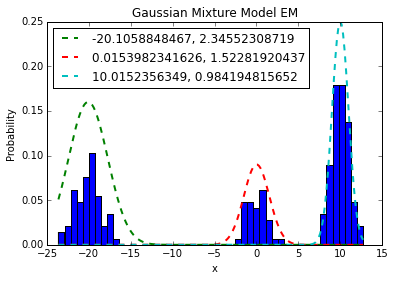

In [142]:
# Plot the 1D example data
plot_gmm(data, max_lam, max_mu, max_sigma)